In [52]:
%%bash 

# Removing all tables that were previously downloaded:
rm *tsv

# Setting date tag:
today=$(date '+%Y-%m-%d')

# Fetching associations:
wget -q https://www.ebi.ac.uk/gwas/api/search/downloads/alternative \
    -O gwas_associations_${today}.tsv
    
# Fetching studies:
wget -q  https://www.ebi.ac.uk/gwas/api/search/downloads/unpublished_studies    \
    -O gwas_unpublished_studies_${today}.tsv

wget -q https://www.ebi.ac.uk/gwas/api/search/downloads/studies_new \
    -O gwas_studies_new_${today}.tsv

# Old style study table, not needed anymore
# wget -q https://www.ebi.ac.uk/gwas/api/search/downloads/studies_alternative \
#     -O gwas_studies_${today}.tsv

# Downloading ancestries:
wget -q https://www.ebi.ac.uk/gwas/api/search/downloads/ancestries_new \
    -O gwas_ancestries_new_${today}.tsv

wget -q  https://www.ebi.ac.uk/gwas/api/search/downloads/unpublished_ancestries   \
    -O gwas_unpublished_ancestries_${today}.tsv

# Also obsoleted dataset
# wget -q  https://www.ebi.ac.uk/gwas/api/search/downloads/ancestry    \
#     -O gwas_ancestries_${today}.tsv


ls -lah *tsv

-rw-r--r--  1 dsuveges  384566875    11M 27 May 10:49 gwas_ancestries_new_2022-05-27.tsv
-rw-r--r--  1 dsuveges  384566875   229M 27 May 10:49 gwas_associations_2022-05-27.tsv
-rw-r--r--  1 dsuveges  384566875    19M 27 May 10:49 gwas_studies_new_2022-05-27.tsv
-rw-r--r--  1 dsuveges  384566875   741K 27 May 10:49 gwas_unpublished_ancestries_2022-05-27.tsv
-rw-r--r--  1 dsuveges  384566875   456K 27 May 10:49 gwas_unpublished_studies_2022-05-27.tsv


In [45]:
import pyspark.sql
import pyspark.sql.types as t
import pyspark.sql.functions as f

global spark

spark = (pyspark.sql.SparkSession
       .builder
       .master("local[*]")
       .getOrCreate()
)
        
# Reading GWAS Catalog data into spark dataframe
studies = spark.read.csv('gwas_ancestries_new_2022-05-24.tsv', sep='\t', header=True).persist()
ustudies = spark.read.csv('gwas_unpublished_ancestries_2022-05-24.tsv', sep='\t', header=True).persist()

In [48]:
all_studies = (
    studies.union(ustudies)
    .persist()
)

all_studies.count()



63037

In [49]:
studies.count()

57229

In [50]:
ustudies.count()

5808

In [43]:
ustudies.columns

['STUDY ACCESSION',
 'PUBMED ID',
 'FIRST AUTHOR',
 'DATE',
 'INITIAL SAMPLE DESCRIPTION',
 'REPLICATION SAMPLE DESCRIPTION',
 'STAGE',
 'NUMBER OF INDIVIDUALS',
 'BROAD ANCESTRAL CATEGORY',
 'COUNTRY OF ORIGIN',
 'COUNTRY OF RECRUITMENT',
 'ADDITIONAL ANCESTRY DESCRIPTION',
 'ANCESTRY DESCRIPTOR',
 'FOUNDER/GENETICALLY ISOLATED POPULATION',
 'NUMBER OF CASES',
 'NUMBER OF CONTROLS',
 'SAMPLE DESCRIPTION',
 'COHORT(S)',
 'COHORT-SPECIFIC REFERENCE']

1 ASMTL
200
{'data': {'search': {'hits': [{'id': 'ENSG00000169093', 'name': 'ASMTL', 'entity': 'target', 'object': {'associatedDiseases': {'count': 19, 'rows': [{'score': 0.07447034071896741, 'datatypeScores': [{'id': 'literature', 'score': 0.6124902785937083}], 'disease': {'id': 'EFO_0000182', 'name': 'hepatocellular carcinoma'}}, {'score': 0.01626151360612688, 'datatypeScores': [{'id': 'literature', 'score': 0.13374477547455663}], 'disease': {'id': 'EFO_0000637', 'name': 'osteosarcoma'}}, {'score': 0.01626151360612688, 'datatypeScores': [{'id': 'literature', 'score': 0.13374477547455663}], 'disease': {'id': 'MONDO_0009901', 'name': 'Bartsocas-Papas syndrome'}}, {'score': 0.012565715059279862, 'datatypeScores': [{'id': 'literature', 'score': 0.10334823559397559}], 'disease': {'id': 'EFO_0000641', 'name': 'papillary thyroid carcinoma'}}, {'score': 0.010025085627962133, 'datatypeScores': [{'id': 'rna_expression', 'score': 0.08245252311075295}], 'disease': {'id': 'MONDO_0004975', 'name':

Name: 0, dtype: object


IndexError: index 0 is out of bounds for axis 0 with size 0

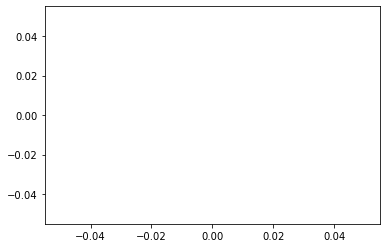

In [55]:
import requests
import json
import pandas as pd
colS=pd.DataFrame(columns=["ID","name","score","count", "rows"])
cntG=0;
for gene_id in genList.split():
    cntG=cntG+1
    print(cntG,gene_id)
    query_string = "query assocs {search(queryString:\""+gene_id+"\", entityNames:\"target\"){hits {id,name,entity,object { ... on Target {associatedDiseases {count rows {score datatypeScores{ id score}disease {id name}}}}}}}}"
    base_url = "https://api.platform.opentargets.org/api/v4/graphql"
    r = requests.post(base_url, json={"query": query_string})
    print(r.status_code)
    if r.status_code==200:
        api_response = json.loads(r.text)
        print(api_response)
        iD=api_response['data']['search']['hits'][0]['id']
        print(iD)
        iG=api_response['data']['search']['hits'][0]['name']
        print(iG)
        dC=api_response['data']['search']['hits'][0]['object']['associatedDiseases']['count']
        print(dC)
        if(dC>0): dS=api_response['data']['search']['hits'][0]['object']['associatedDiseases']['rows'][0]['score']
        aD=api_response['data']['search']['hits'][0]['object']['associatedDiseases']#['rows'][0]['datatypeScores']
        #print(aD)
        dataOIDP=pd.DataFrame(aD,columns=["count","rows"])
        if(dataOIDP.empty==False): print(dataOIDP.iloc[0])
        dataOIDP["ID"]=iD
        dataOIDP["name"]=iG
        dataOIDP["score"]=dS
        colS=pd.concat([colS,dataOIDP])
#print(colS)
colSs=colS['rows'].astype('str').str.split(',').str[0]
colSs=colSs.astype('str').str.split(':').str[1]
colSd=colS['rows'].astype('str').str.split(',').str[-1]
colSd=colSd.astype('str').str.split('\'').str[3]
colS["dDcore"]=colSs
colS["disease"]=colSd
colS.to_csv("openTargetResults.csv")
colScnt=colS['disease'].value_counts()
colScnt.to_csv("openTargetResultsCount.csv")
colScnt[colScnt>50].plot(kind="barh").figure.savefig("openTargetResult50D.svg",dpi=100,bbox_inches = "tight")
neoplasmL=set(colS[colS['disease']=='neoplasm'].ID)
cancerL=set(colS[colS['disease']=='cancer'].ID)
diffLnc=neoplasmL-cancerL
diffLcn=cancerL-neoplasmL
commonL=neoplasmL.intersection(cancerL)
print(len(commonL),len(diffLnc),len(diffLcn))

In [54]:
genList="""
ASMTL
BCAS3
DHX37
"""

In [61]:
COLUMNS = {
        'id': 'targetId',
        'symbol': 'display_name',
        'description': 'description',
        'seq_region_name': 'chromosome',
        'start': 'start',
        'end': 'end',
    }

pd.DataFrame(columns=COLUMNS.keys())

,id,symbol,description,seq_region_name,start,end


In [63]:
x = pd.DataFrame([{'a': 12, 'b':21},{'a': 4} , {'a': 132, 'b':211}])
b = {'a': 'cica'}
x[b.keys()].rename(columns=b)

,cica
0,12
1,4
2,132


In [67]:
import json
gene_list = ['a', 'b']
print(json.dumps({'symbols': gene_list}))

{"symbols": ["a", "b"]}
